In [1]:
trial_number_ml = "008"
random_state_init = 888

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 17:37:57,493] A new study created in memory with name: no-name-89e2a8d9-34ff-4f2d-bf8b-157c2d24f63d


[I 2024-05-01 17:38:36,199] Trial 2 finished with value: 0.6158783612186227 and parameters: {'n_estimators': 138, 'max_depth': 75, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6158783612186227.


[I 2024-05-01 17:39:05,599] Trial 1 finished with value: 0.6114177307774358 and parameters: {'n_estimators': 450, 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 2 with value: 0.6158783612186227.


[I 2024-05-01 17:39:34,874] Trial 3 finished with value: 0.6130121191804061 and parameters: {'n_estimators': 601, 'max_depth': 95, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 2 with value: 0.6158783612186227.


[I 2024-05-01 17:39:45,202] Trial 0 finished with value: 0.6139695649082173 and parameters: {'n_estimators': 619, 'max_depth': 72, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.6158783612186227.


[I 2024-05-01 17:40:00,048] Trial 6 finished with value: 0.617793760603013 and parameters: {'n_estimators': 226, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 6 with value: 0.617793760603013.


[I 2024-05-01 17:40:08,408] Trial 4 finished with value: 0.6187481587582158 and parameters: {'n_estimators': 523, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6187481587582158.


[I 2024-05-01 17:40:28,512] Trial 7 pruned. 


[I 2024-05-01 17:40:29,331] Trial 5 finished with value: 0.62034153130365 and parameters: {'n_estimators': 445, 'max_depth': 83, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.62034153130365.


[I 2024-05-01 17:40:47,982] Trial 11 pruned. 


[I 2024-05-01 17:41:23,031] Trial 8 finished with value: 0.6225718465242434 and parameters: {'n_estimators': 458, 'max_depth': 73, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.6225718465242434.


[I 2024-05-01 17:41:55,448] Trial 13 pruned. 


[I 2024-05-01 17:41:59,031] Trial 9 finished with value: 0.6232108209144749 and parameters: {'n_estimators': 681, 'max_depth': 54, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6232108209144749.


[I 2024-05-01 17:42:23,994] Trial 15 pruned. 


[I 2024-05-01 17:42:45,763] Trial 14 pruned. 


[I 2024-05-01 17:43:13,617] Trial 12 finished with value: 0.6184286715631 and parameters: {'n_estimators': 878, 'max_depth': 66, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6232108209144749.


[I 2024-05-01 17:43:17,056] Trial 10 finished with value: 0.6212964373876207 and parameters: {'n_estimators': 995, 'max_depth': 56, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6232108209144749.


[I 2024-05-01 17:43:22,573] Trial 17 pruned. 


[I 2024-05-01 17:43:27,672] Trial 16 pruned. 


[I 2024-05-01 17:43:52,888] Trial 18 pruned. 


[I 2024-05-01 17:43:53,988] Trial 19 pruned. 


[I 2024-05-01 17:44:01,671] Trial 20 pruned. 


[I 2024-05-01 17:44:30,446] Trial 22 pruned. 


[I 2024-05-01 17:45:39,380] Trial 23 finished with value: 0.6232123447007792 and parameters: {'n_estimators': 361, 'max_depth': 59, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.6232123447007792.


[I 2024-05-01 17:46:06,831] Trial 21 pruned. 


[I 2024-05-01 17:47:22,567] Trial 26 finished with value: 0.6184246081329554 and parameters: {'n_estimators': 354, 'max_depth': 80, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.6232123447007792.


[I 2024-05-01 17:47:59,364] Trial 27 finished with value: 0.619699001412042 and parameters: {'n_estimators': 388, 'max_depth': 80, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.6232123447007792.


[I 2024-05-01 17:48:13,836] Trial 24 finished with value: 0.6209794898363453 and parameters: {'n_estimators': 998, 'max_depth': 53, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.6232123447007792.


[I 2024-05-01 17:48:33,128] Trial 25 finished with value: 0.6212959294588527 and parameters: {'n_estimators': 991, 'max_depth': 53, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.6232123447007792.


[I 2024-05-01 17:48:54,642] Trial 31 pruned. 


[I 2024-05-01 17:49:00,354] Trial 29 finished with value: 0.6232108209144749 and parameters: {'n_estimators': 247, 'max_depth': 69, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.6232123447007792.


[I 2024-05-01 17:49:00,487] Trial 28 finished with value: 0.622574894096852 and parameters: {'n_estimators': 398, 'max_depth': 70, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.6232123447007792.


[I 2024-05-01 17:49:05,174] Trial 33 pruned. 


[I 2024-05-01 17:49:11,032] Trial 30 pruned. 


[I 2024-05-01 17:49:17,514] Trial 34 pruned. 


[I 2024-05-01 17:49:17,589] Trial 32 pruned. 


[I 2024-05-01 17:49:27,746] Trial 35 pruned. 


[I 2024-05-01 17:49:38,050] Trial 38 pruned. 


[I 2024-05-01 17:49:44,835] Trial 37 pruned. 


[I 2024-05-01 17:49:45,115] Trial 39 pruned. 


[I 2024-05-01 17:49:55,550] Trial 40 pruned. 


[I 2024-05-01 17:49:59,932] Trial 36 finished with value: 0.621297961173925 and parameters: {'n_estimators': 205, 'max_depth': 63, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.6232123447007792.


[I 2024-05-01 17:50:01,961] Trial 41 pruned. 


[I 2024-05-01 17:50:04,278] Trial 43 pruned. 


[I 2024-05-01 17:50:08,619] Trial 42 pruned. 


[I 2024-05-01 17:51:24,268] Trial 44 pruned. 


[I 2024-05-01 17:51:51,087] Trial 45 pruned. 


[I 2024-05-01 17:52:03,900] Trial 47 pruned. 


[I 2024-05-01 17:52:07,986] Trial 48 pruned. 


[I 2024-05-01 17:52:08,759] Trial 46 finished with value: 0.6235277684657503 and parameters: {'n_estimators': 539, 'max_depth': 70, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 46 with value: 0.6235277684657503.


[I 2024-05-01 17:52:16,965] Trial 49 pruned. 


Best trial for RandomForestClassifier:
  Value: 0.6235277684657503
  Params: 
    n_estimators: 539
    max_depth: 70
    min_samples_split: 18
    min_samples_leaf: 3
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 539, 'max_depth': 70, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


[I 2024-05-01 17:52:29,568] A new study created in memory with name: no-name-559ff6cd-808a-457f-97bd-3fbeec0b0231


RandomForestClassifier accuracy: 0.6191



[I 2024-05-01 17:52:56,155] Trial 2 finished with value: 0.6193866252196791 and parameters: {'n_estimators': 176, 'max_depth': 10, 'learning_rate': 0.1249253452541612, 'min_child_weight': 6, 'subsample': 0.9637208940861461, 'colsample_bytree': 0.7975331163930275, 'gamma': 0.012791799519121239, 'reg_lambda': 0.01405839424055881, 'reg_alpha': 8.29362545842813}. Best is trial 2 with value: 0.6193866252196791.


[I 2024-05-01 17:53:08,638] Trial 3 finished with value: 0.5989927772529181 and parameters: {'n_estimators': 480, 'max_depth': 4, 'learning_rate': 0.1332694353526828, 'min_child_weight': 7, 'subsample': 0.5165916259565274, 'colsample_bytree': 0.9634922230581416, 'gamma': 4.95596436709865, 'reg_lambda': 0.2418182199329787, 'reg_alpha': 1.6005288670586362}. Best is trial 2 with value: 0.6193866252196791.


[I 2024-05-01 17:53:12,138] Trial 4 finished with value: 0.6082325094728714 and parameters: {'n_estimators': 132, 'max_depth': 6, 'learning_rate': 0.06345985423692867, 'min_child_weight': 6, 'subsample': 0.7093232195466703, 'colsample_bytree': 0.5021070078405372, 'gamma': 2.6286736206899675, 'reg_lambda': 5.5254243376194285, 'reg_alpha': 0.08882846568481477}. Best is trial 2 with value: 0.6193866252196791.


[I 2024-05-01 17:53:25,742] Trial 5 finished with value: 0.5967482400268186 and parameters: {'n_estimators': 311, 'max_depth': 4, 'learning_rate': 0.19033464071602998, 'min_child_weight': 6, 'subsample': 0.9256686961850455, 'colsample_bytree': 0.90996163313639, 'gamma': 4.247082559934584, 'reg_lambda': 0.9898387308413334, 'reg_alpha': 5.4366928233994285}. Best is trial 2 with value: 0.6193866252196791.


[I 2024-05-01 17:53:31,590] Trial 0 finished with value: 0.6075935350826401 and parameters: {'n_estimators': 901, 'max_depth': 7, 'learning_rate': 0.05792691290425244, 'min_child_weight': 9, 'subsample': 0.8496373180389146, 'colsample_bytree': 0.8585262883779522, 'gamma': 2.2288965735949073, 'reg_lambda': 0.1464838521436021, 'reg_alpha': 0.7524753991057946}. Best is trial 2 with value: 0.6193866252196791.


[I 2024-05-01 17:53:35,451] Trial 7 pruned. 


[I 2024-05-01 17:53:36,909] Trial 1 pruned. 


[I 2024-05-01 17:53:37,963] Trial 9 pruned. 


[I 2024-05-01 17:53:38,005] Trial 6 finished with value: 0.6104536819756398 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.1255974727410964, 'min_child_weight': 9, 'subsample': 0.7478786705326786, 'colsample_bytree': 0.9009354739896569, 'gamma': 1.9486796046407533, 'reg_lambda': 1.0694796896230683, 'reg_alpha': 0.2595207110024404}. Best is trial 2 with value: 0.6193866252196791.


[I 2024-05-01 17:53:38,849] Trial 8 pruned. 


[I 2024-05-01 17:53:39,838] Trial 10 pruned. 


[I 2024-05-01 17:53:43,381] Trial 13 finished with value: 0.606307967370656 and parameters: {'n_estimators': 101, 'max_depth': 10, 'learning_rate': 0.2405654165776528, 'min_child_weight': 1, 'subsample': 0.9638985575655548, 'colsample_bytree': 0.6514812144528093, 'gamma': 0.3104504496387994, 'reg_lambda': 0.016065365094180436, 'reg_alpha': 9.339972977566273}. Best is trial 2 with value: 0.6193866252196791.


[I 2024-05-01 17:53:43,949] Trial 14 pruned. 


[I 2024-05-01 17:53:44,279] Trial 12 pruned. 


[I 2024-05-01 17:53:45,815] Trial 15 pruned. 


[I 2024-05-01 17:53:46,594] Trial 16 pruned. 


[I 2024-05-01 17:53:47,809] Trial 17 pruned. 


[I 2024-05-01 17:53:48,154] Trial 19 pruned. 


[I 2024-05-01 17:53:49,328] Trial 20 pruned. 


[I 2024-05-01 17:53:53,424] Trial 18 pruned. 


[I 2024-05-01 17:54:02,256] Trial 22 finished with value: 0.6200220441085342 and parameters: {'n_estimators': 303, 'max_depth': 9, 'learning_rate': 0.09837278207537448, 'min_child_weight': 4, 'subsample': 0.599064825714761, 'colsample_bytree': 0.593940834390474, 'gamma': 2.694342672290697, 'reg_lambda': 3.1636012230972295, 'reg_alpha': 0.7161354485027345}. Best is trial 22 with value: 0.6200220441085342.


[I 2024-05-01 17:54:04,444] Trial 11 finished with value: 0.6130090716077977 and parameters: {'n_estimators': 771, 'max_depth': 3, 'learning_rate': 0.094290116637979, 'min_child_weight': 7, 'subsample': 0.5920733565064487, 'colsample_bytree': 0.5304417551735193, 'gamma': 2.894280789399839, 'reg_lambda': 3.317537661783507, 'reg_alpha': 0.026568974836470916}. Best is trial 22 with value: 0.6200220441085342.


[I 2024-05-01 17:54:08,094] Trial 25 pruned. 


[I 2024-05-01 17:54:09,862] Trial 21 finished with value: 0.6238452239457939 and parameters: {'n_estimators': 313, 'max_depth': 9, 'learning_rate': 0.026459764880041814, 'min_child_weight': 4, 'subsample': 0.9069178360648876, 'colsample_bytree': 0.5280267674941231, 'gamma': 0.06613610606076903, 'reg_lambda': 0.4936230300404319, 'reg_alpha': 4.115753281968909}. Best is trial 21 with value: 0.6238452239457939.


[I 2024-05-01 17:54:11,414] Trial 23 pruned. 


[I 2024-05-01 17:54:11,954] Trial 26 pruned. 


[I 2024-05-01 17:54:13,914] Trial 29 pruned. 


[I 2024-05-01 17:54:17,647] Trial 24 finished with value: 0.6142834648868842 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.10605256697231541, 'min_child_weight': 4, 'subsample': 0.6390034383546698, 'colsample_bytree': 0.6078558158124753, 'gamma': 3.036744883962931, 'reg_lambda': 3.580505783499321, 'reg_alpha': 0.5119440173206093}. Best is trial 21 with value: 0.6238452239457939.


[I 2024-05-01 17:54:18,147] Trial 28 pruned. 


[I 2024-05-01 17:54:19,919] Trial 31 pruned. 


[I 2024-05-01 17:54:20,951] Trial 33 pruned. 


[I 2024-05-01 17:54:22,750] Trial 32 pruned. 


[I 2024-05-01 17:54:24,048] Trial 34 pruned. 


[I 2024-05-01 17:54:25,322] Trial 35 pruned. 


[I 2024-05-01 17:54:25,435] Trial 30 pruned. 


[I 2024-05-01 17:54:27,657] Trial 36 pruned. 


[I 2024-05-01 17:54:29,941] Trial 38 pruned. 


[I 2024-05-01 17:54:32,645] Trial 39 pruned. 


[I 2024-05-01 17:54:33,581] Trial 37 pruned. 


[I 2024-05-01 17:54:34,760] Trial 40 pruned. 


[I 2024-05-01 17:54:36,340] Trial 42 pruned. 


[I 2024-05-01 17:54:37,010] Trial 41 pruned. 


[I 2024-05-01 17:54:39,586] Trial 43 pruned. 


[I 2024-05-01 17:54:42,143] Trial 44 pruned. 


[I 2024-05-01 17:54:46,101] Trial 45 pruned. 


[I 2024-05-01 17:54:46,991] Trial 46 pruned. 


[I 2024-05-01 17:54:51,791] Trial 49 pruned. 


[I 2024-05-01 17:54:55,542] Trial 27 finished with value: 0.6181066447241439 and parameters: {'n_estimators': 531, 'max_depth': 9, 'learning_rate': 0.012844122126293085, 'min_child_weight': 4, 'subsample': 0.9981137021107186, 'colsample_bytree': 0.6160343848249927, 'gamma': 0.014714361749134576, 'reg_lambda': 0.5614336244755848, 'reg_alpha': 4.359517008997501}. Best is trial 21 with value: 0.6238452239457939.


[I 2024-05-01 17:55:01,457] Trial 48 finished with value: 0.6161927691260577 and parameters: {'n_estimators': 620, 'max_depth': 6, 'learning_rate': 0.11717583927556235, 'min_child_weight': 3, 'subsample': 0.5984960699557866, 'colsample_bytree': 0.5547054770519532, 'gamma': 3.3356740217708154, 'reg_lambda': 8.365450275165482, 'reg_alpha': 0.021172379446265127}. Best is trial 21 with value: 0.6238452239457939.


[I 2024-05-01 17:55:03,693] Trial 47 finished with value: 0.6139588984040879 and parameters: {'n_estimators': 998, 'max_depth': 4, 'learning_rate': 0.1624545613522429, 'min_child_weight': 3, 'subsample': 0.6194357746580537, 'colsample_bytree': 0.5640145617819086, 'gamma': 2.9855591493785445, 'reg_lambda': 2.127228510010847, 'reg_alpha': 0.022184033326191944}. Best is trial 21 with value: 0.6238452239457939.


Best trial for XGBClassifier:
  Value: 0.6238452239457939
  Params: 
    n_estimators: 313
    max_depth: 9
    learning_rate: 0.026459764880041814
    min_child_weight: 4
    subsample: 0.9069178360648876
    colsample_bytree: 0.5280267674941231
    gamma: 0.06613610606076903
    reg_lambda: 0.4936230300404319
    reg_alpha: 4.115753281968909

Best hyperparameters for XGBClassifier: {'n_estimators': 313, 'max_depth': 9, 'learning_rate': 0.026459764880041814, 'min_child_weight': 4, 'subsample': 0.9069178360648876, 'colsample_bytree': 0.5280267674941231, 'gamma': 0.06613610606076903, 'reg_lambda': 0.4936230300404319, 'reg_alpha': 4.115753281968909}


[I 2024-05-01 17:57:11,588] A new study created in memory with name: no-name-77a4b381-c8c1-478f-a8ed-76594eafc496


XGBClassifier accuracy: 0.6025



[I 2024-05-01 17:57:12,178] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 0, 'learning_rate': 0.2048517341943123, 'n_estimators': 110, 'min_child_weight': 0.0010091177166976133, 'min_child_samples': 1900, 'subsample': 0.9283835079725257, 'colsample_bytree': 0.9671057900151601, 'reg_alpha': 5.418157928499459e-05, 'reg_lambda': 4.4451905967787194e-09}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 17:57:12,607] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 57, 'max_depth': 1, 'learning_rate': 0.47430716600398154, 'n_estimators': 744, 'min_child_weight': 0.03417369106926851, 'min_child_samples': 1687, 'subsample': 0.8609129381855987, 'colsample_bytree': 0.8151377247939131, 'reg_alpha': 3.894636304651565e-05, 'reg_lambda': 1.0921315905581965e-05}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 17:57:12,615] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 13, 'learning_rate': 0.07665471125819637, 'n_estimators': 682, 'min_child_weight': 0.011205481198442693, 'min_child_samples': 1411, 'subsample': 0.8294773452595955, 'colsample_bytree': 0.8134553266907352, 'reg_alpha': 0.05491992180511226, 'reg_lambda': 3.5833922380393674e-06}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 17:57:13,155] Trial 4 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'max_depth': 11, 'learning_rate': 0.448595587003125, 'n_estimators': 841, 'min_child_weight': 0.0023699052160872894, 'min_child_samples': 1562, 'subsample': 0.8052882242661384, 'colsample_bytree': 0.8030942518244303, 'reg_alpha': 1.1801432565173241e-08, 'reg_lambda': 9.795887879431198e-10}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 17:57:13,371] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.42816937208996464, 'n_estimators': 344, 'min_child_weight': 0.004855074343418994, 'min_child_samples': 1259, 'subsample': 0.8741090545288225, 'colsample_bytree': 0.9444689839415064, 'reg_alpha': 3.461796606213902e-08, 'reg_lambda': 1.3857238408188173e-10}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 17:57:14,524] Trial 7 finished with value: 0.5773016792125072 and parameters: {'boosting_type': 'goss', 'num_leaves': 67, 'max_depth': 0, 'learning_rate': 0.3964166583580267, 'n_estimators': 264, 'min_child_weight': 0.012970784340233838, 'min_child_samples': 491, 'subsample': 0.9435107471636535, 'colsample_bytree': 0.9373378838686095, 'reg_alpha': 3.0577534621440944e-06, 'reg_lambda': 0.7550727830120135}. Best is trial 7 with value: 0.5773016792125072.


[I 2024-05-01 17:57:15,726] Trial 8 finished with value: 0.5970672192931664 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 1, 'learning_rate': 0.17108351024837812, 'n_estimators': 625, 'min_child_weight': 0.01236099325654984, 'min_child_samples': 534, 'subsample': 0.8947507192470142, 'colsample_bytree': 0.8146328365929588, 'reg_alpha': 0.00017422120292777532, 'reg_lambda': 1.0118465997961444e-09}. Best is trial 8 with value: 0.5970672192931664.


[I 2024-05-01 17:57:16,267] Trial 10 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 53, 'max_depth': 5, 'learning_rate': 0.339712156517435, 'n_estimators': 262, 'min_child_weight': 0.05704329849116972, 'min_child_samples': 1425, 'subsample': 0.8338062539420642, 'colsample_bytree': 0.933394450844867, 'reg_alpha': 0.18646539799059253, 'reg_lambda': 9.751369743008708e-09}. Best is trial 8 with value: 0.5970672192931664.


[I 2024-05-01 17:57:17,741] Trial 0 finished with value: 0.5884679852497485 and parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'max_depth': 6, 'learning_rate': 0.3039242678791222, 'n_estimators': 217, 'min_child_weight': 0.005529185438661475, 'min_child_samples': 167, 'subsample': 0.9905189283851645, 'colsample_bytree': 0.8592848647495994, 'reg_alpha': 2.2912210472191955e-07, 'reg_lambda': 0.010986315445018937}. Best is trial 8 with value: 0.5970672192931664.


[I 2024-05-01 17:57:18,587] Trial 12 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 85, 'max_depth': 14, 'learning_rate': 0.2792482080170721, 'n_estimators': 757, 'min_child_weight': 0.0019302622867682943, 'min_child_samples': 1360, 'subsample': 0.8729226186566701, 'colsample_bytree': 0.8107840441585622, 'reg_alpha': 1.382822088089294e-06, 'reg_lambda': 6.0481031750071396e-06}. Best is trial 8 with value: 0.5970672192931664.


[I 2024-05-01 17:57:19,682] Trial 11 finished with value: 0.5664655268745111 and parameters: {'boosting_type': 'goss', 'num_leaves': 90, 'max_depth': 5, 'learning_rate': 0.08760215509184906, 'n_estimators': 963, 'min_child_weight': 0.007680547582594492, 'min_child_samples': 897, 'subsample': 0.8431597371872677, 'colsample_bytree': 0.8433532564617637, 'reg_alpha': 0.0007713673131551215, 'reg_lambda': 7.739199761166291e-05}. Best is trial 8 with value: 0.5970672192931664.


[I 2024-05-01 17:57:23,251] Trial 13 finished with value: 0.5776252298377675 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'max_depth': 3, 'learning_rate': 0.0013538217839417777, 'n_estimators': 996, 'min_child_weight': 0.01759544885755111, 'min_child_samples': 804, 'subsample': 0.9188340323227828, 'colsample_bytree': 0.8770152286223356, 'reg_alpha': 0.0014970300748022264, 'reg_lambda': 3.693796105428049e-07}. Best is trial 8 with value: 0.5970672192931664.


[I 2024-05-01 17:57:28,044] Trial 14 finished with value: 0.5884547791017788 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 9, 'learning_rate': 0.1806551425628678, 'n_estimators': 487, 'min_child_weight': 0.023183545926763572, 'min_child_samples': 131, 'subsample': 0.9920584823804804, 'colsample_bytree': 0.8704356978132568, 'reg_alpha': 1.4884941048744196e-10, 'reg_lambda': 0.08911604733651791}. Best is trial 8 with value: 0.5970672192931664.


[I 2024-05-01 17:57:28,334] Trial 6 finished with value: 0.6034457887625839 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'max_depth': 4, 'learning_rate': 0.04735261130559179, 'n_estimators': 556, 'min_child_weight': 0.0027782874037124705, 'min_child_samples': 47, 'subsample': 0.8145718827110975, 'colsample_bytree': 0.9015539310784729, 'reg_alpha': 1.3059448567859954e-07, 'reg_lambda': 2.9454300489164823e-10}. Best is trial 6 with value: 0.6034457887625839.


[I 2024-05-01 17:57:31,016] Trial 17 finished with value: 0.586229035240098 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 3, 'learning_rate': 0.11749995259938623, 'n_estimators': 540, 'min_child_weight': 0.002992736113664585, 'min_child_samples': 493, 'subsample': 0.895713115005187, 'colsample_bytree': 0.9131347624958809, 'reg_alpha': 1.2148665557483166e-09, 'reg_lambda': 7.34244634196589e-08}. Best is trial 6 with value: 0.6034457887625839.


[I 2024-05-01 17:57:33,189] Trial 18 finished with value: 0.5773021871412752 and parameters: {'boosting_type': 'goss', 'num_leaves': 99, 'max_depth': 3, 'learning_rate': 0.022847030620565457, 'n_estimators': 443, 'min_child_weight': 0.09534885614133128, 'min_child_samples': 448, 'subsample': 0.8043213794306748, 'colsample_bytree': 0.9941458630866374, 'reg_alpha': 0.002349392977967947, 'reg_lambda': 1.4761312344542305e-10}. Best is trial 6 with value: 0.6034457887625839.


[I 2024-05-01 17:57:45,437] Trial 19 finished with value: 0.5957887625839353 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 9, 'learning_rate': 0.15688871151868455, 'n_estimators': 624, 'min_child_weight': 0.0011924801759787605, 'min_child_samples': 75, 'subsample': 0.9582218023196881, 'colsample_bytree': 0.8951717835370557, 'reg_alpha': 2.9405812932144267e-07, 'reg_lambda': 0.0004254615926540561}. Best is trial 6 with value: 0.6034457887625839.


[I 2024-05-01 17:57:46,032] Trial 20 pruned. 


[I 2024-05-01 17:57:48,504] Trial 21 finished with value: 0.6034468046201201 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 2, 'learning_rate': 0.12667585701048342, 'n_estimators': 396, 'min_child_weight': 0.00809062703025713, 'min_child_samples': 383, 'subsample': 0.9664797502354976, 'colsample_bytree': 0.8995149279699335, 'reg_alpha': 9.011559118148985e-09, 'reg_lambda': 1.6642042579146256e-09}. Best is trial 21 with value: 0.6034468046201201.


[I 2024-05-01 17:57:52,439] Trial 15 finished with value: 0.5916521906967767 and parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'max_depth': 9, 'learning_rate': 0.20648827712101664, 'n_estimators': 540, 'min_child_weight': 0.00413737108380109, 'min_child_samples': 116, 'subsample': 0.9831988696397669, 'colsample_bytree': 0.8643923387653556, 'reg_alpha': 2.6957920940604933e-10, 'reg_lambda': 0.007219176404154725}. Best is trial 21 with value: 0.6034468046201201.


[I 2024-05-01 17:57:53,057] Trial 23 pruned. 


[I 2024-05-01 17:57:54,458] Trial 16 finished with value: 0.6047156106827578 and parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'max_depth': 8, 'learning_rate': 0.2754226260323616, 'n_estimators': 550, 'min_child_weight': 0.005132988945609172, 'min_child_samples': 75, 'subsample': 0.9692297148497133, 'colsample_bytree': 0.8527048333394623, 'reg_alpha': 9.876065214166691e-08, 'reg_lambda': 0.003295640855001233}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:57:54,807] Trial 24 finished with value: 0.5980195857332967 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 1, 'learning_rate': 0.1337801113889415, 'n_estimators': 448, 'min_child_weight': 0.00715836178849772, 'min_child_samples': 664, 'subsample': 0.8957136885817882, 'colsample_bytree': 0.9196359235281004, 'reg_alpha': 1.2979732976478037e-07, 'reg_lambda': 1.3941649128009819e-09}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:00,034] Trial 22 finished with value: 0.5993015979439044 and parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'max_depth': 9, 'learning_rate': 0.054104444616575965, 'n_estimators': 376, 'min_child_weight': 0.0030683869267938914, 'min_child_samples': 259, 'subsample': 0.9627222720720141, 'colsample_bytree': 0.9029909120686226, 'reg_alpha': 6.391709011656608e-09, 'reg_lambda': 3.7838969147478656e-07}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:06,524] Trial 9 finished with value: 0.5820757017035931 and parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'max_depth': 15, 'learning_rate': 0.4800325262022608, 'n_estimators': 917, 'min_child_weight': 0.0054217410009913996, 'min_child_samples': 165, 'subsample': 0.8600916029136599, 'colsample_bytree': 0.9315628990100663, 'reg_alpha': 8.838540428523034e-08, 'reg_lambda': 5.219828898366772e-05}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:07,425] Trial 25 finished with value: 0.6028037667997441 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 8, 'learning_rate': 0.12855480085054852, 'n_estimators': 430, 'min_child_weight': 0.007861472801854006, 'min_child_samples': 288, 'subsample': 0.9518182041328948, 'colsample_bytree': 0.8884031444430547, 'reg_alpha': 1.0348017979879507e-07, 'reg_lambda': 0.0007355018557969009}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:09,579] Trial 29 pruned. 


[I 2024-05-01 17:58:10,743] Trial 26 finished with value: 0.6037561332398745 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 8, 'learning_rate': 0.2652158674857845, 'n_estimators': 519, 'min_child_weight': 0.0031084957510304416, 'min_child_samples': 282, 'subsample': 0.9591635601800304, 'colsample_bytree': 0.8857864770558049, 'reg_alpha': 1.3352627780811161e-09, 'reg_lambda': 0.000836453751020806}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:13,470] Trial 30 finished with value: 0.5922865937280956 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 4, 'learning_rate': 0.3499727832963956, 'n_estimators': 314, 'min_child_weight': 0.0014689998642041925, 'min_child_samples': 351, 'subsample': 0.976513389996841, 'colsample_bytree': 0.9583039455231567, 'reg_alpha': 1.9522036004165262e-09, 'reg_lambda': 0.005093139311211927}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:13,743] Trial 32 pruned. 


[I 2024-05-01 17:58:16,872] Trial 33 pruned. 


[I 2024-05-01 17:58:17,758] Trial 31 finished with value: 0.6034422332612074 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'max_depth': 11, 'learning_rate': 0.36724431622459913, 'n_estimators': 305, 'min_child_weight': 0.0016348958184764161, 'min_child_samples': 364, 'subsample': 0.9799216184825046, 'colsample_bytree': 0.8828725732684026, 'reg_alpha': 1.36965590524642e-09, 'reg_lambda': 0.0033007409139099355}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:23,783] Trial 28 finished with value: 0.6034437570475116 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': 7, 'learning_rate': 0.2659756452110687, 'n_estimators': 498, 'min_child_weight': 0.009025168416592117, 'min_child_samples': 350, 'subsample': 0.9412016876137006, 'colsample_bytree': 0.8846959037629396, 'reg_alpha': 1.422755632888581e-06, 'reg_lambda': 0.0011756993200674696}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:24,448] Trial 35 pruned. 


[I 2024-05-01 17:58:30,258] Trial 36 pruned. 


[I 2024-05-01 17:58:31,023] Trial 27 finished with value: 0.5980241570922094 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 7, 'learning_rate': 0.3504217656209083, 'n_estimators': 520, 'min_child_weight': 0.007396720838701008, 'min_child_samples': 39, 'subsample': 0.9411708671430812, 'colsample_bytree': 0.8861175932034832, 'reg_alpha': 2.51016855194495e-06, 'reg_lambda': 0.0006779775939946628}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:32,991] Trial 38 pruned. 


[I 2024-05-01 17:58:33,328] Trial 40 pruned. 


[I 2024-05-01 17:58:34,527] Trial 34 finished with value: 0.6040812076514389 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': 6, 'learning_rate': 0.31215242295781864, 'n_estimators': 489, 'min_child_weight': 0.00245033262446161, 'min_child_samples': 230, 'subsample': 0.9310338227434342, 'colsample_bytree': 0.8572287508704174, 'reg_alpha': 3.6077036248845474e-07, 'reg_lambda': 0.00017233064847202182}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:37,075] Trial 39 finished with value: 0.5938703156269366 and parameters: {'boosting_type': 'goss', 'num_leaves': 67, 'max_depth': 5, 'learning_rate': 0.09039062298374806, 'n_estimators': 687, 'min_child_weight': 0.010383273637472885, 'min_child_samples': 226, 'subsample': 0.9675510890954356, 'colsample_bytree': 0.9098066741561237, 'reg_alpha': 2.9500447921982882e-08, 'reg_lambda': 0.00010526221334476568}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:37,625] Trial 41 finished with value: 0.5957831753674865 and parameters: {'boosting_type': 'goss', 'num_leaves': 61, 'max_depth': 2, 'learning_rate': 0.041240283300424216, 'n_estimators': 472, 'min_child_weight': 0.010577260160642865, 'min_child_samples': 238, 'subsample': 0.9112274015663568, 'colsample_bytree': 0.9068602168572955, 'reg_alpha': 1.517771988132434e-08, 'reg_lambda': 0.5105799684410872}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:40,204] Trial 43 finished with value: 0.5938784424872255 and parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'max_depth': 10, 'learning_rate': 0.386403963698314, 'n_estimators': 183, 'min_child_weight': 0.005170504167696092, 'min_child_samples': 586, 'subsample': 0.9536259094298029, 'colsample_bytree': 0.8554512532161915, 'reg_alpha': 2.623014463392665e-10, 'reg_lambda': 1.3411760783436603e-06}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:47,605] Trial 44 finished with value: 0.5948338564999645 and parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'max_depth': 8, 'learning_rate': 0.3858607778611276, 'n_estimators': 385, 'min_child_weight': 0.005546584216156215, 'min_child_samples': 426, 'subsample': 0.9517920254907962, 'colsample_bytree': 0.8561419734528047, 'reg_alpha': 5.936707273881772e-07, 'reg_lambda': 2.2145757472163185e-05}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:48,645] Trial 42 finished with value: 0.6024908826786131 and parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'max_depth': 10, 'learning_rate': 0.39246411564521605, 'n_estimators': 393, 'min_child_weight': 0.005416351063561462, 'min_child_samples': 230, 'subsample': 0.9545438491748447, 'colsample_bytree': 0.8557545153600403, 'reg_alpha': 2.1066936923509625e-08, 'reg_lambda': 2.362564510674237e-05}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:50,199] Trial 47 pruned. 


[I 2024-05-01 17:58:50,481] Trial 48 pruned. 


[I 2024-05-01 17:58:50,778] Trial 45 finished with value: 0.5973811192718332 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 8, 'learning_rate': 0.3190357795761243, 'n_estimators': 397, 'min_child_weight': 0.003874120940587385, 'min_child_samples': 415, 'subsample': 0.9490793482153869, 'colsample_bytree': 0.8707492285874406, 'reg_alpha': 4.691747143402507e-07, 'reg_lambda': 2.012375679954673e-05}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:51,369] Trial 46 pruned. 


[I 2024-05-01 17:58:53,556] Trial 37 finished with value: 0.597386198559514 and parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'max_depth': 5, 'learning_rate': 0.09117481535272472, 'n_estimators': 673, 'min_child_weight': 0.0022484544917431423, 'min_child_samples': 191, 'subsample': 0.9150153341775684, 'colsample_bytree': 0.9151414531803921, 'reg_alpha': 2.625748248653475e-08, 'reg_lambda': 5.2729762047778615e-05}. Best is trial 16 with value: 0.6047156106827578.


[I 2024-05-01 17:58:54,496] Trial 49 pruned. 


Best trial for LGBMClassifier:
  Value: 0.6047156106827578
  Params: 
    boosting_type: dart
    num_leaves: 55
    max_depth: 8
    learning_rate: 0.2754226260323616
    n_estimators: 550
    min_child_weight: 0.005132988945609172
    min_child_samples: 75
    subsample: 0.9692297148497133
    colsample_bytree: 0.8527048333394623
    reg_alpha: 9.876065214166691e-08
    reg_lambda: 0.003295640855001233

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 55, 'max_depth': 8, 'learning_rate': 0.2754226260323616, 'n_estimators': 550, 'min_child_weight': 0.005132988945609172, 'min_child_samples': 75, 'subsample': 0.9692297148497133, 'colsample_bytree': 0.8527048333394623, 'reg_alpha': 9.876065214166691e-08, 'reg_lambda': 0.003295640855001233}


LGBMClassifier accuracy: 0.5860
LGBMClassifier accuracy: 0.5860



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_008/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

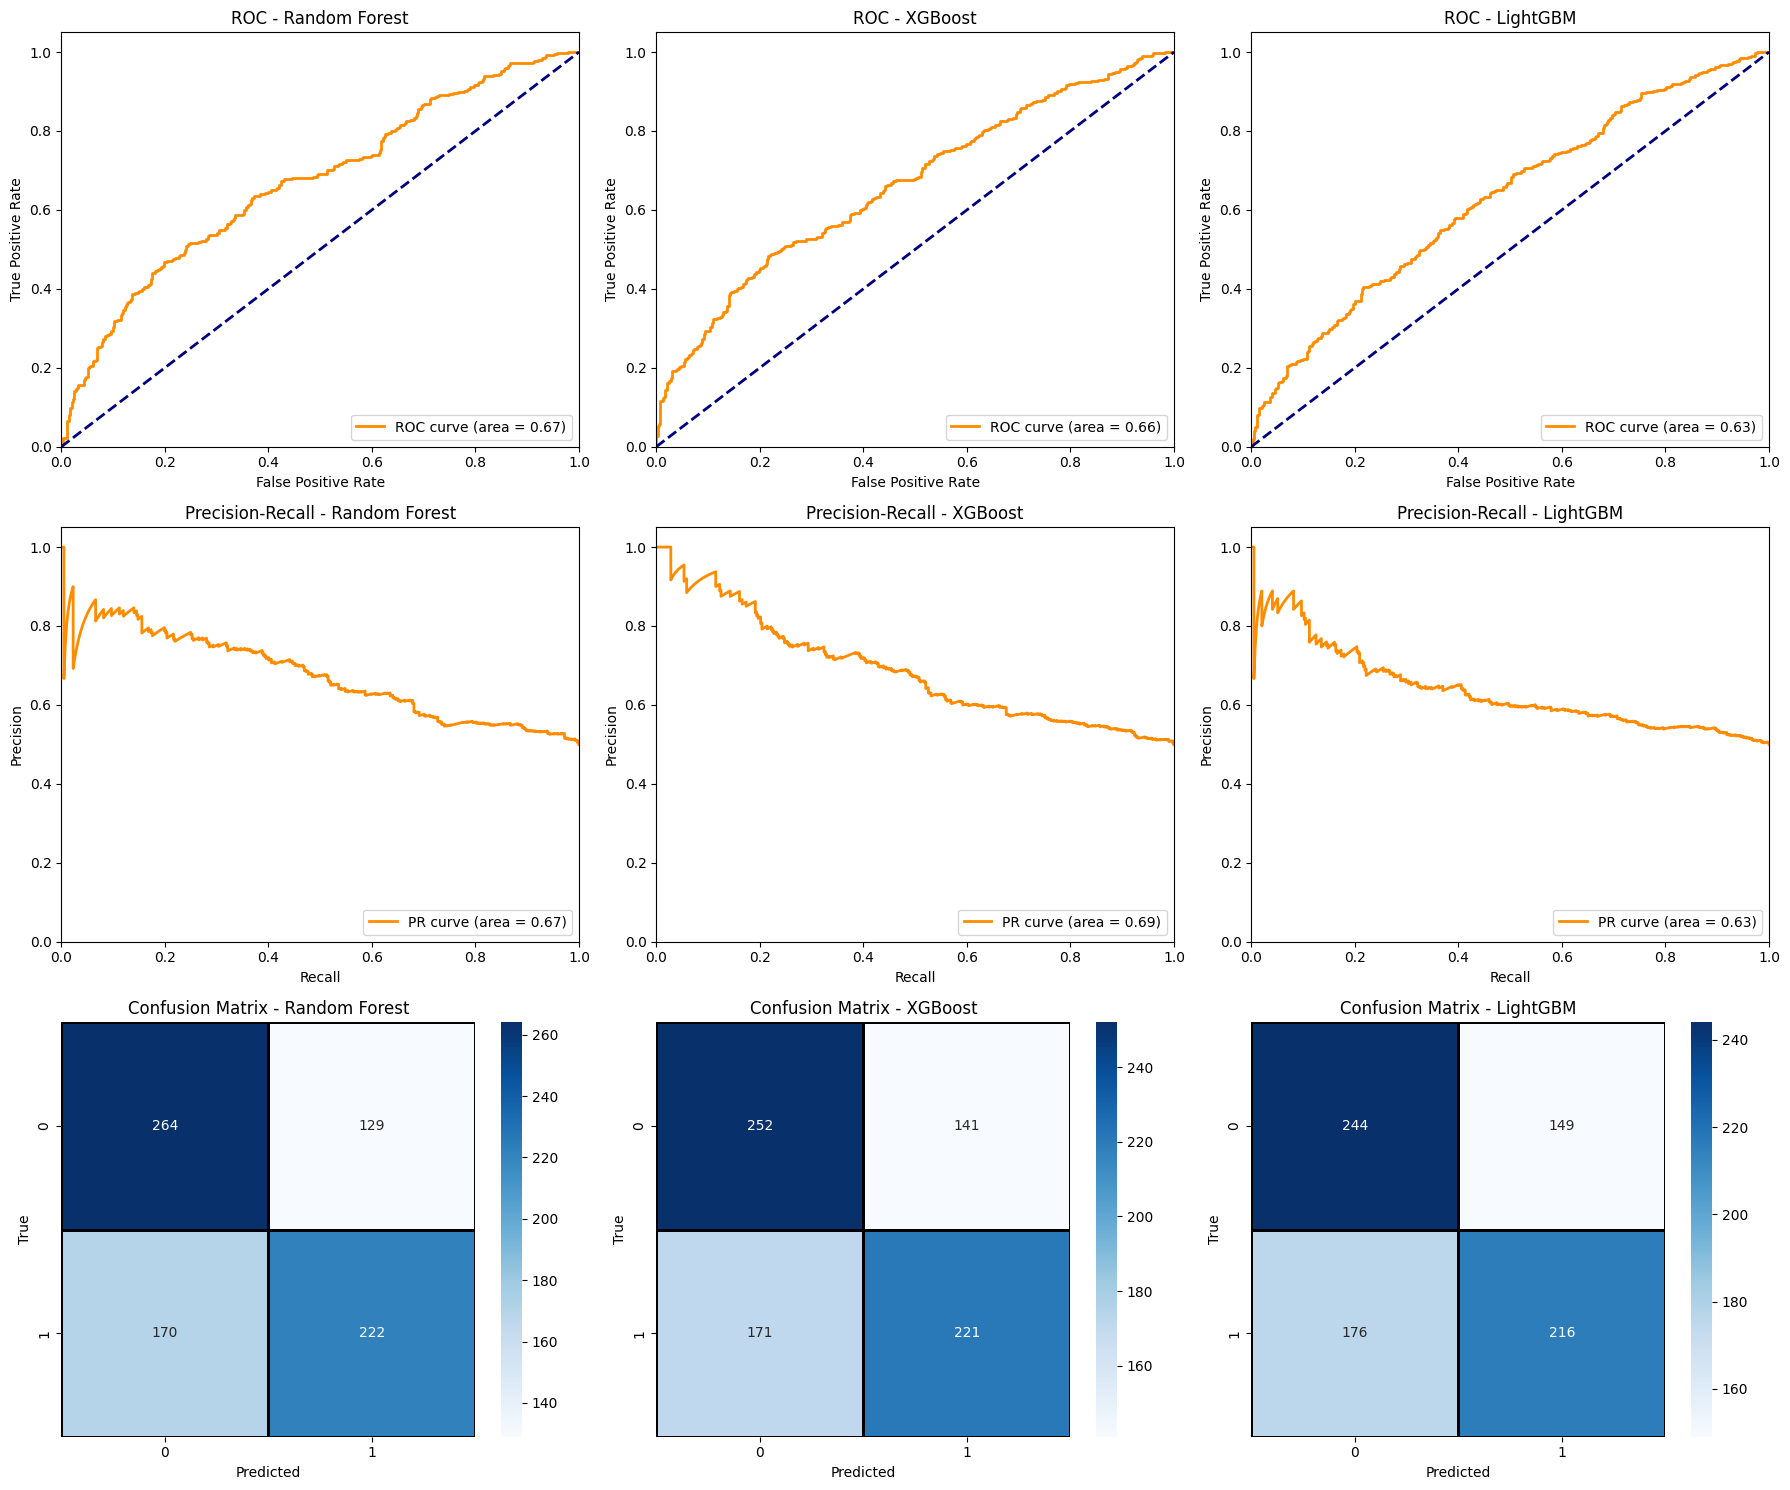

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.619108280254777, 'Precision': 0.6324786324786325, 'Recall': 0.5663265306122449, 'F1 Score': 0.5975773889636609, 'ROC AUC': 0.6696720673002025}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.6025477707006369, 'Precision': 0.6104972375690608, 'Recall': 0.5637755102040817, 'F1 Score': 0.5862068965517242, 'ROC AUC': 0.663654774887054}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.5859872611464968, 'Precision': 0.5917808219178082, 'Recall': 0.5510204081632653, 'F1 Score': 0.570673712021136, 'ROC AUC': 0.6299137975801008}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.5859872611464968,
 'Precision': 0.5917808219178082,
 'Recall': 0.5510204081632653,
 'F1 Score': 0.570673712021136,
 'ROC AUC': 0.6299137975801008}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.6191


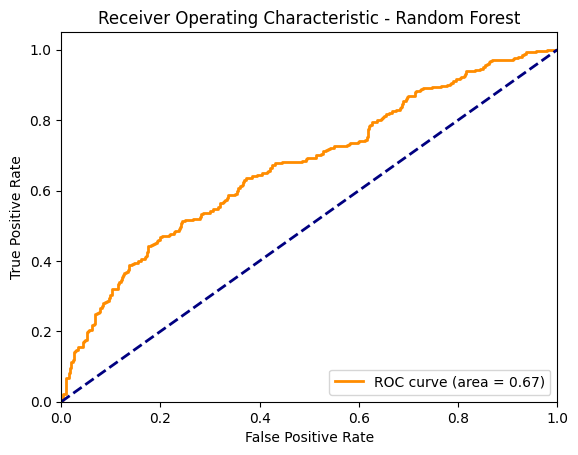

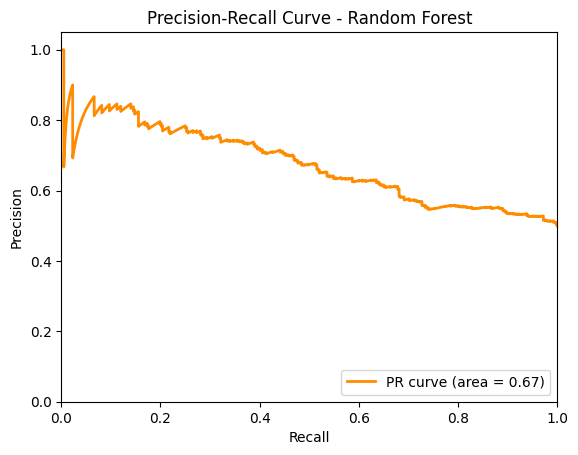

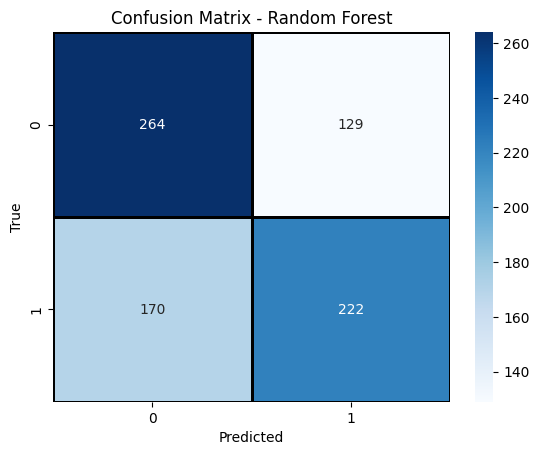

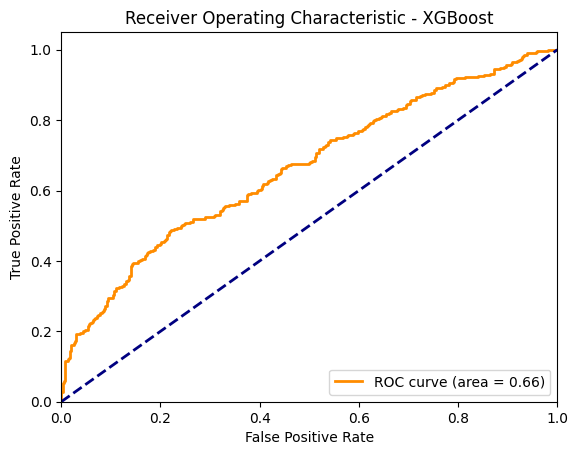

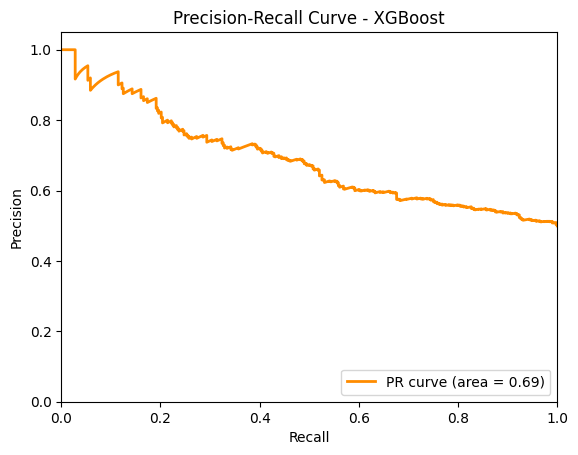

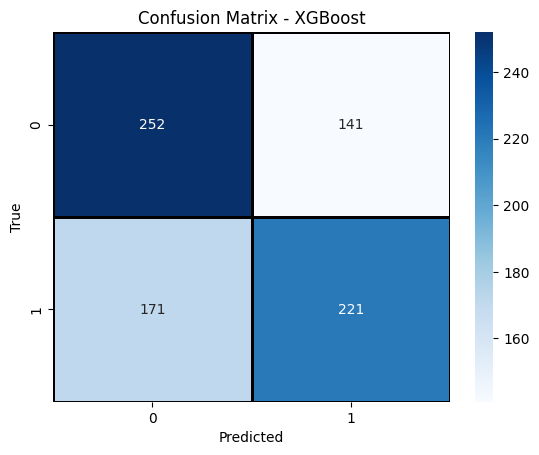

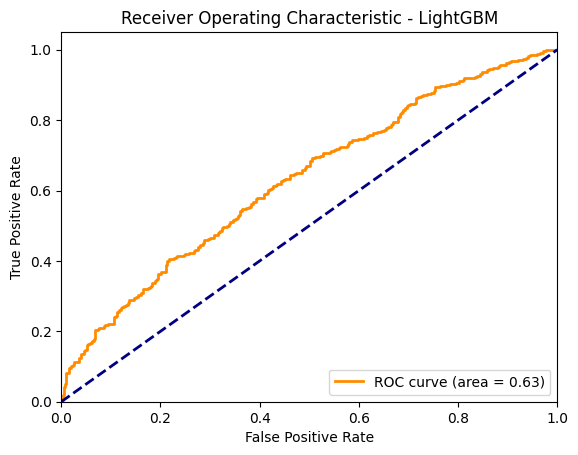

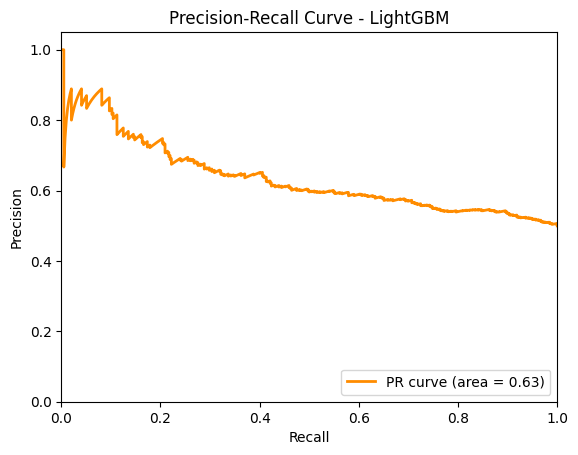

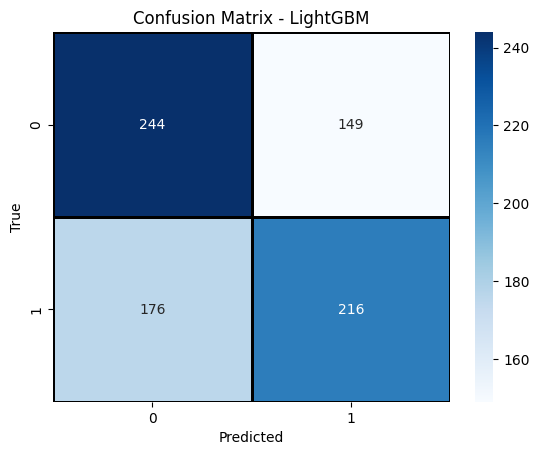

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

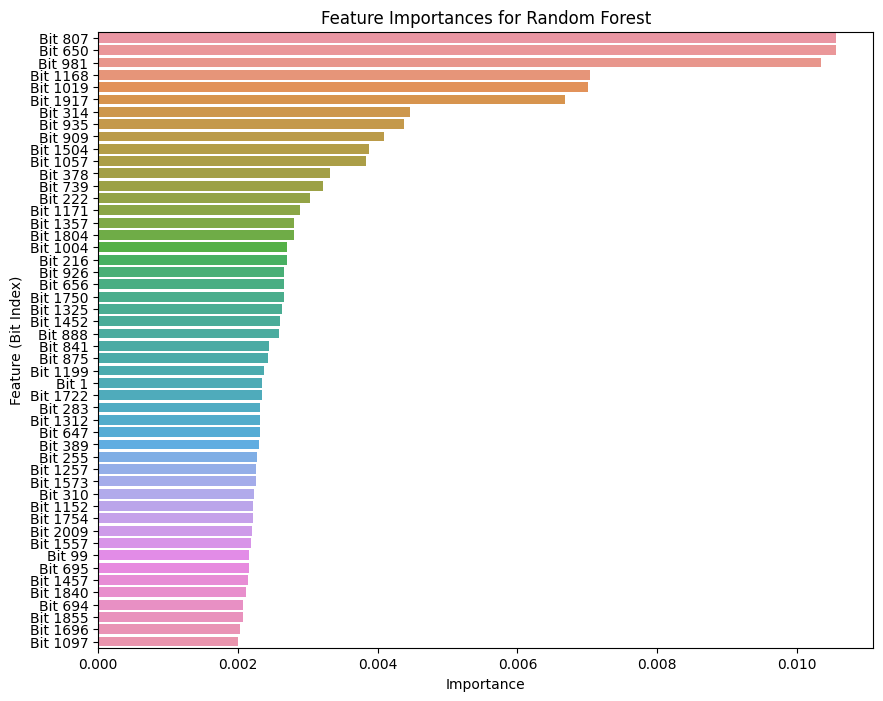

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
